In [182]:
# data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = [15,5]

#pull data from yahoo finances API
from pandas_datareader import data as pdr
import yfinance as yf

import time

## INVESTING STRATEGY: evaluate which indicators have historically performed better for a series of stocks.
## For each stock invest using the best performing indicator 

## Possible investing strategies are given by these indicators:
0) simple moving average <br>
1) exponential moving average <br>
2) cross simple average<br>
3) cross exponential average<br>
4) MACD<br>
5) MACD conservative


In [143]:
class PullData: # "BTC-USD", start="2016-01-01", end="2021-06-16"
    def __init__(self,stock,start,end):
        self.stock = stock
        self.start = start
        self.end = end
        self.df = pd.DataFrame()
        
    def request_yahoo(self):
        yf.pdr_override() 
        data = pdr.get_data_yahoo(self.stock, start=self.start, end=self.end)
        self.df = data
        self.df.index.name = None
        
    def filling_missing_dates(self):
        self.missing_dates = pd.date_range(start = self.start, end = self.end ).difference(self.df.index)
        print(f'missing values: {len(self.missing_dates)}')
        for day in self.missing_dates:
            self.df.loc[pd.to_datetime(day)] = self.df.loc[pd.to_datetime(day) - pd.DateOffset(days=1) ]
    
    def show_missing_dates(self):
        print(pd.DataFrame({'missing values': self.missing_dates.year.value_counts()}))
        return self.missing_dates
        
    def get_data(self):
        return self.df.sort_index()
    
class Indicator: # 0-5
    def __init__(self,indicator,period,period_1,period_2):
        self.indicators = {0:'sma',1:'ema',2:'cross simple average',3:'cross exp average',4:'MACD',5:'MACD conservative'}
        self.indicator = indicator
        self.period = period
        self.period_1 = period_1
        self.period_2 = period_2
        self.df_indicator = pd.DataFrame()
        
        if self.indicator in [0,2]:
            self.type_average = 'sma'
        elif self.indicator in [1,3]:
            self.type_average = 'ema'
        else:
            self.type_average = 'MACD'
            
    
    def data_prep(self,dataframe):
        self.dataframe = dataframe
        if self.indicator in [0,1]:  # simple moving average or exponential average
            if self.indicator == 0:  #sma
                self.df_indicator = pd.concat([self.dataframe['Close'],self.dataframe['High'],self.dataframe['Low'],self.dataframe['Close'].rolling(self.period).mean(),self.dataframe['Volume']],axis=1)
            else:     #ema
                self.df_indicator = pd.concat([self.dataframe['Close'],self.dataframe['High'],self.dataframe['Low'],self.dataframe['Close'].ewm(span=self.period, adjust=False,min_periods=self.period).mean(),self.dataframe['Volume']],axis=1)
            self.df_indicator.columns = ['Close','High','Low',self.indicators[self.indicator],'Volume']
            
        if self.indicator == 2:   #cross simple average
            self.df_indicator = pd.concat([self.dataframe['Close'],self.dataframe['Close'].rolling(self.period_1).mean(),self.dataframe['Close'].rolling(self.period_2).mean(),self.dataframe['Volume']],axis=1)
            self.df_indicator.columns = ['Close',self.indicators[self.indicator] + '1',self.indicators[self.indicator] + '2','Volume']
       
        if self.indicator == 3:  #cross exponential average
            self.df_indicator = pd.concat([self.dataframe['Close'],self.dataframe['Close'].ewm(span=self.period_1, adjust=False,min_periods=self.period_1).mean(),self.dataframe['Close'].ewm(span=self.period_2, adjust=False,min_periods=self.period_2).mean(),self.dataframe['Volume']],axis=1)
            self.df_indicator.columns = ['Close',self.indicators[self.indicator] + '1',self.indicators[self.indicator] + '2','Volume']
            
        if self.indicator in [4,5]:  #MACD
            self.macd_12 = self.dataframe['Close'].ewm(span=12, adjust=False,min_periods=12).mean()
            self.macd_26 = self.dataframe['Close'].ewm(span=26, adjust=False,min_periods=26).mean()
            self.macd_line = (self.macd_12 - self.macd_26).dropna()
            self.macd_line_ewm = self.macd_line.ewm(span=9, adjust=False, min_periods=9).mean().dropna()
            self.df_indicator = pd.concat([self.dataframe['Close'][33:],self.macd_line,self.macd_line_ewm],axis=1)
            self.df_indicator.columns = ['Close',self.indicators[self.indicator] + '1',self.indicators[self.indicator] + '2']
        self.df_indicator = self.df_indicator.dropna()
        return self.df_indicator
    


            
    def buying_selling_days(self):
        assert self.indicator in [0,1], 'This method does nos correspond to the chosen indicator' 
        self.df_indicator['buy_or_sell'] = self.df_indicator.apply(lambda x: 'buy' if (x['Low'] > x[self.indicators[self.indicator]]) else ('sell' if (x['High'] < x[self.indicators[self.indicator]]) else 'none'),axis=1)
        self.buy_day = []
        self.sell_day = []
        marker = 'sell'
        list_ = list(zip(self.df_indicator['buy_or_sell'].index,self.df_indicator['buy_or_sell']))
        for i,j in list_:
            if j == 'buy' and marker == 'sell':
                self.buy_day.append(i)
                marker = 'buy'
            elif j == 'sell' and marker == 'buy':
                self.sell_day.append(i)
                marker = 'sell'
            else:
                pass
        if len(self.buy_day) > len(self.sell_day):
            self.sell_day.append(list_[-1][0])
        
        self.buy_sell_dates = np.array(list(zip(self.buy_day,self.sell_day)))
        return self.buy_sell_dates
        
    def crossing_rolling_average(self): # for 2, 3 (crossing average) and 4, 5 (MACD)
        assert self.indicator in [2,3,4,5], 'This method does nos correspond to the chosen indicator' 
        self.index_buy = []
        self.index_sell = []
        # FASTER LINE    A ------ B
        # SLOWER LINE    C ------ D
        buy_sell_indicator = 0
        for i in self.df_indicator.index[:-1]:
            abcd = self.df_indicator.loc[i:pd.to_datetime(i)+pd.DateOffset(days=1)][[self.indicators[self.indicator] + '1',self.indicators[self.indicator] + '2']] # 4 points dataframe
            
            a = abcd[self.indicators[self.indicator] + '1'][0]
            b = abcd[self.indicators[self.indicator] + '1'][1]
            c = abcd[self.indicators[self.indicator] + '2'][0]
            d = abcd[self.indicators[self.indicator] + '2'][1]
            if (a<c and d<b and buy_sell_indicator == 0): # buying signal
                if ((self.indicator == 5) and ( (b > 0) or (buy_sell_indicator == 1))):
                    pass
                else:
                    self.index_buy.append(pd.to_datetime(i)+pd.DateOffset(days=1))  
                    buy_sell_indicator = 1
                    
            if (c<a and b<d and buy_sell_indicator == 1): # selling signal
                if ((self.indicator == 5) and ((b < 0) or (buy_sell_indicator == 0))):
                    pass
                else:
                    self.index_sell.append(pd.to_datetime(i)+pd.DateOffset(days=1))
                    buy_sell_indicator = 0
           
        if len(self.index_buy) > len(self.index_sell):
            self.index_sell.append(self.df_indicator.index[-1])    

        self.buy_sell_dates = np.array(list(zip(self.index_buy,self.index_sell)))    
        return self.buy_sell_dates     

        
    def get_profit(self):  # porcentage of profit
        # operation costs have to be added
        
        self.returns = (100 * 
                        (self.df_indicator['Close'].loc[self.buy_sell_dates[:,1]].values 
                         - self.df_indicator['Close'].loc[self.buy_sell_dates[:,0]].values) 
                        / (self.df_indicator['Close'].loc[self.buy_sell_dates[:,0]].values) )
        self.total_profit = np.sum(self.returns)
        return self.total_profit
    
    def number_transactions(self):
        return len(self.buy_sell_dates)

    def plot_results(self):
        fig,ax = plt.subplots(2,1,figsize=(17, 9),sharex=True,gridspec_kw={'height_ratios':[3,1]}) 
        if self.indicator in [0,1]:
            #volume_outliers_per_month = self.df_indicator.groupby([self.df_indicator.index.month,self.df_indicator.index.year]).median()['Volume']
            
            ax[0].fill_between(self.df_indicator.index,self.df_indicator['Low'],self.df_indicator['High'],label='Low-High')
            ax[0].plot(self.df_indicator[self.indicators[self.indicator]],
                       label=f"{self.type_average} {str(self.period)} days",color='black')
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,0]].index,self.df_indicator.loc[self.buy_sell_dates[:,0]]['Close'],label='buy',marker="^",color='black',s=120)
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,1]].index,self.df_indicator.loc[self.buy_sell_dates[:,1]]['Close'],label='sell',marker="v",color='black',s=120)
            volume_outliers_indexes = self.df_indicator['Volume'] [self.df_indicator['Volume'] > (self.df_indicator['Volume'].rolling(30,min_periods=1,center=True).median() + (3*self.df_indicator['Volume'].rolling(30,min_periods=1,center=True).std()))].index # outliers (large volume)
            for outlier in volume_outliers_indexes:
                ax[0].axvline(x=outlier,color='k', linestyle='--',alpha=0.5)
            ax[1].bar(self.df_indicator.index,self.df_indicator['Volume'])
            ax[1].set_title('Volume')
            for i,j in enumerate(self.df_indicator.loc[self.buy_sell_dates[:,1]].index):
                h = np.sign((-1)**i) * 0.2*(i % 2) # to avoid overlapping
                ax[0].annotate(round(self.returns[i],1),
                             (j,(self.df_indicator.loc[j]['Close'] + ((h + 0.25)*(np.abs(self.df_indicator.iloc[-1]['Close'] - self.df_indicator.iloc[0]['Close']))))))

            


            
        if self.indicator in [2,3]:
            ax[0].plot(self.df_indicator[self.indicators[self.indicator] + '1'],
                       label= f"{self.type_average} {str(self.period_1)} days")
            ax[0].plot(self.df_indicator[self.indicators[self.indicator] + '2'],
                       label= f"{self.type_average} {str(self.period_2)} days")
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,0]].index,
                          self.df_indicator.loc[self.buy_sell_dates[:,0]]['Close'],
                          label='buy', marker="^",color='black',s=120)
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,1]].index,
                          self.df_indicator.loc[self.buy_sell_dates[:,1]]['Close'],
                          label='sell',marker="v",color='black',s=120)
            volume_outliers_indexes = self.df_indicator['Volume'] [self.df_indicator['Volume'] > (self.df_indicator['Volume'].rolling(30,min_periods=1,
                                                                                                                                      center=True).median() + (3*self.df_indicator['Volume'].rolling(30,min_periods=1,center=True).std()))].index
            
            
            for outlier in volume_outliers_indexes:
                ax[0].axvline(x=outlier,color='k', linestyle='--',alpha=0.5)
            ax[1].bar(self.df_indicator.index,self.df_indicator['Volume'])
            ax[1].set_title('Volume')
            
            
        if self.indicator in [4,5]:
            
            ax[0].set_title(self.indicators[self.indicator])
            ax[0].plot(self.df_indicator['Close'],label='Close')
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,0]].index,self.df_indicator.loc[self.buy_sell_dates[:,0]]['Close'],
                          label='buy',marker="^",color='black',s=120)
            ax[0].scatter(self.df_indicator.loc[self.buy_sell_dates[:,1]].index,self.df_indicator.loc[self.buy_sell_dates[:,1]]['Close'],
                          label='sell',marker="v",color='black',s=120)
            
            ax[1].plot(self.df_indicator[self.indicators[self.indicator] + '1'],label='MACD line')
            ax[1].plot(self.df_indicator[self.indicators[self.indicator] + '2'],label='Signal line')
            ax[1].legend(fontsize='large')
            ax[1].axhline(0)           

        ax[0].grid()    
        ax[0].legend(fontsize='xx-large')
        fig.suptitle(self.indicators[self.indicator],fontsize=26)
        fig.tight_layout()    
        #plt.legend(fontsize='xx-large')
        plt.grid()
        plt.show()  


## 1) bitcoin (BTC)

In [7]:
stock = "BTC-USD"
start_date = "2018-04-01"
end_date = "2021-06-12"

# PULL THE DATA
bitcoin = PullData(stock,start_date,end_date)
bitcoin.request_yahoo()

# FILL MISSING DATES
bitcoin.filling_missing_dates()

# STORE THE DATA
btc = bitcoin.get_data()

[*********************100%***********************]  1 of 1 completed
missing values: 4


In [8]:
btc

,Open,High,Low,Close,Adj Close,Volume
2018-04-01,7003.060059,7060.950195,6526.870117,6844.229980,6844.229980,4.532100e+09
2018-04-02,6844.859863,7135.470215,6816.580078,7083.799805,7083.799805,4.333440e+09
2018-04-03,7102.259766,7530.939941,7072.490234,7456.109863,7456.109863,5.499700e+09
2018-04-04,7456.410156,7469.879883,6803.879883,6853.839844,6853.839844,4.936000e+09
2018-04-05,6848.649902,6933.819824,6644.799805,6811.470215,6811.470215,5.639320e+09
...,...,...,...,...,...,...
2021-06-08,33589.519531,34017.386719,31114.443359,33472.632812,33472.632812,4.990205e+10
2021-06-09,33416.976562,37537.371094,32475.865234,37345.121094,37345.121094,5.397292e+10
2021-06-10,37389.515625,38334.324219,35847.593750,36702.597656,36702.597656,4.357603e+10
2021-06-11,36697.031250,37608.695312,36044.449219,37334.398438,37334.398438,3.869974e+10


Text(0.5, 0, 'date')

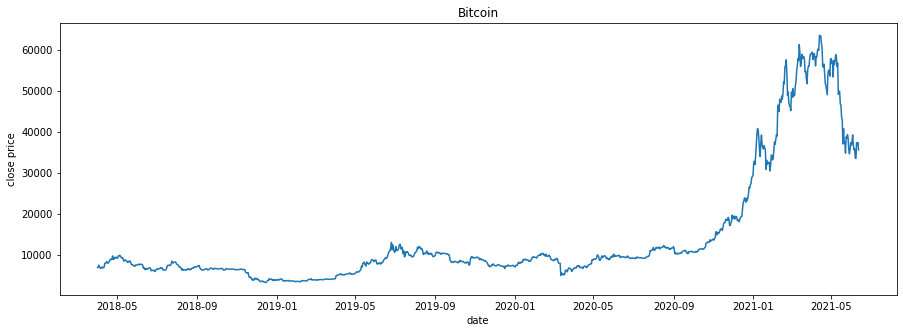

In [21]:
plt.plot(btc['Close'])
plt.title('Bitcoin')
plt.ylabel('close price')
plt.xlabel('date')

### Apply 'simple moving average' (18 days) strategy to Bitcoin in the last year

#### Simple Moving Average (SMA) Strategy: https://corporatefinanceinstitute.com/<br> we can see that when the price surpasses the SMA line, the prices often trend upward for some time. It is often used as a buy indicator for technical traders. However, when the price intersects and falls below the SMA line, we see a downtrend in prices for a bit as well. It may sometimes be a good indicator to sell.

total profit= 169.56%
number of transactions= 9


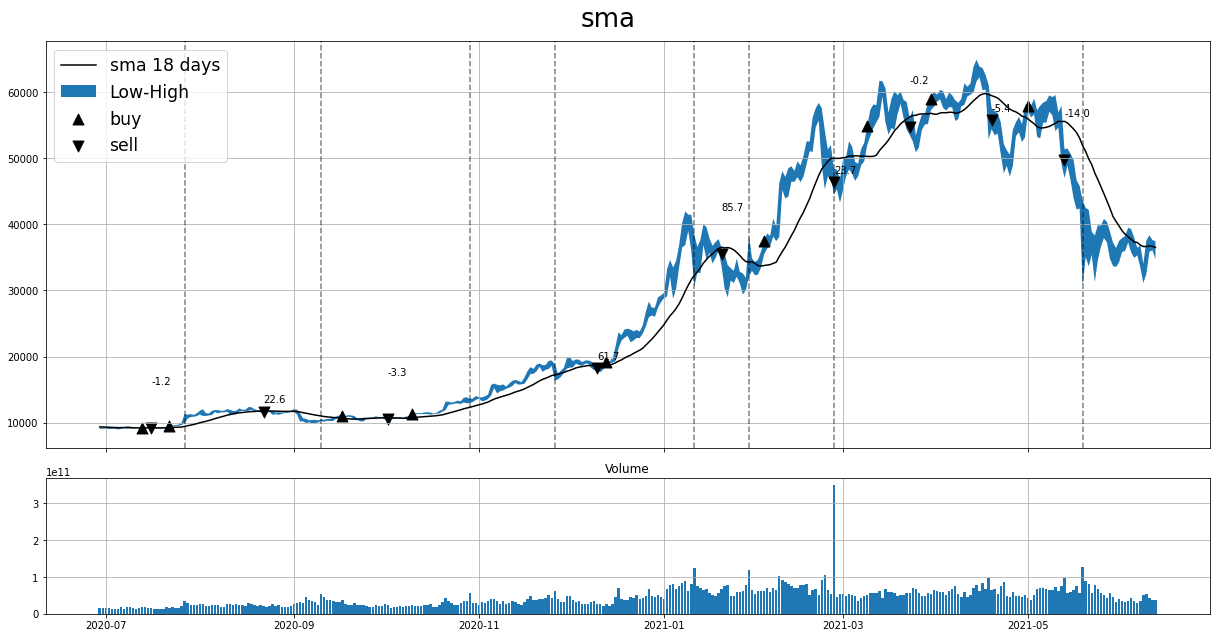

In [83]:
# {0:'sma',1:'ema',2:'cross simple average',3:'cross exp average',4:'MACD',5:'MACD conservative'}

# CHOOSE ONE INDICATOR AND ITS PARAMETERS
indicator_sma = Indicator(0,18,_,_)  # indicator   period   period_1   period_2
indicator_sma.data_prep(btc['2020-06-12':end_date])

# WHEN TO BUY AND SELL ACCORDING TO THIS INDICATOR 
buying_selling_dates = indicator_sma.buying_selling_days()

# WHAT WOULD HAVE BEEN THE TOTAL PROFIT (%), ASSUMING THAT EACH TIME THE SAME AMOUNT IS INVSTED. 
# THE GAIN/LOOSE PORCENTAGE FOR EACH BUY/SELL TRANSACTION IS INDICATED NEXT TO EACH SELL SIGNAL
profit = indicator_sma.get_profit()
print(f'total profit= {profit:.2f}%')

# HOW MANY TRANSACTIONS TOOK PLACE
num_trans = indicator_sma.number_transactions()
print(f'number of transactions= {num_trans}')

# PLOT. DAYS WITH LARGE VOLUME ARE INDICATED WITH VERTICAL LINES IN THE TOP GRAPH
indicator_sma.plot_results()

### Apply 'cross simple average' (5 and 14 days periods) strategy to Bitcoin in the last year

#### Crossover Moving Average Strategy: www.investopedia.com<br>When the shorter-term MA crosses above the longer-term MA, it's a buy signal, as it indicates that the trend is shifting up. This is known as a "golden cross." Meanwhile, when the shorter-term MA crosses below the longer-term MA, it's a sell signal, as it indicates that the trend is shifting down. This is known as a "dead/death cross."

total profit= 164.03%
number of transactions= 14


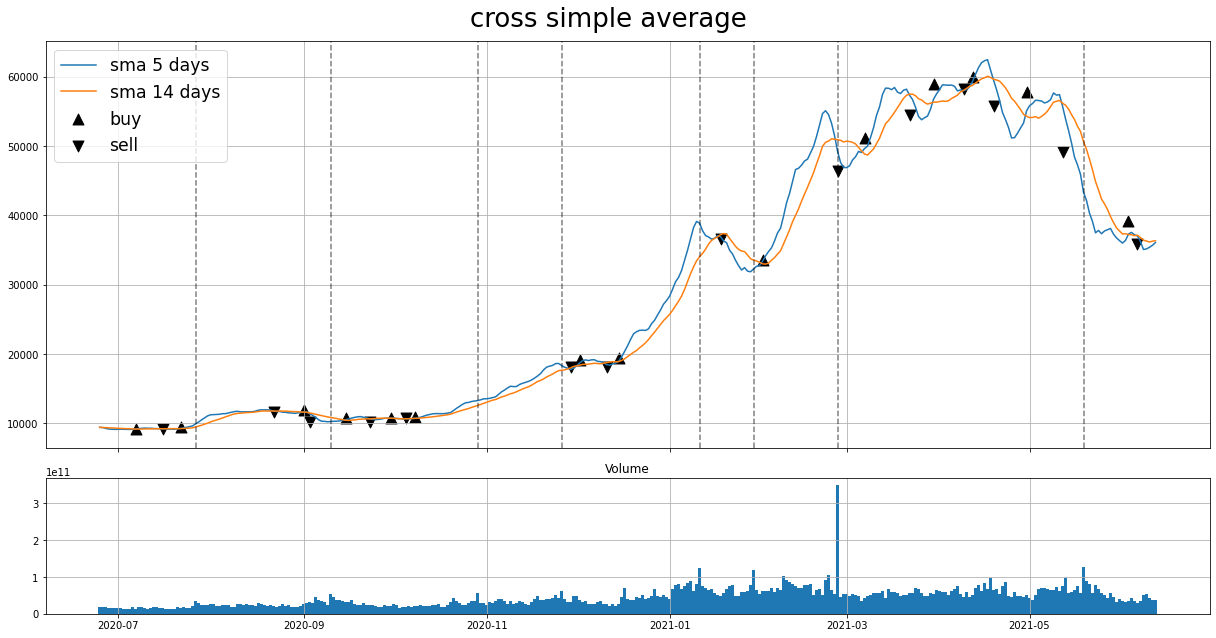

In [84]:
# {0:'sma',1:'ema',2:'cross simple average',3:'cross exp average',4:'MACD',5:'MACD conservative'}

# CHOOSE ONE INDICATOR AND ITS PARAMETERS
indicator_sma = Indicator(2,_,5,14)  # indicator   period   period_1(shorter)   period_2(longer)
indicator_sma.data_prep(btc['2020-06-12':end_date])

# WHEN TO BUY AND SELL ACCORDING TO THIS INDICATOR
buying_selling_dates = indicator_sma.crossing_rolling_average()

# WHAT WOULD HAVE BEEN THE TOTAL PROFIT (%), ASSUMING THAT EACH TIME THE SAME AMOUNT IS INVSTED. 
# THE GAIN/LOOSE PORCENTAGE FOR EACH BUY/SELL TRANSACTION IS INDICATED NEXT TO EACH SELL SIGNAL
profit = indicator_sma.get_profit()
print(f'total profit= {profit:.2f}%')

# HOW MANY TRANSACTIONS TOOK PLACE
num_trans = indicator_sma.number_transactions()
print(f'number of transactions= {num_trans}')

# PLOT. DAYS WITH LARGE VOLUME ARE INDICATED WITH VERTICAL LINES IN THE TOP GRAPH
indicator_sma.plot_results()

## 2) McDonalds (MCD)

In [128]:
# PULL THE DATA
mcdonals = PullData("MCD","2017-01-03","2021-06-15")
mcdonals.request_yahoo()

# FILL MISSING VALUES
mcdonals.filling_missing_dates()
missing_dates_ = mcdonals.show_missing_dates()

#STORE THE DATA
mcd = mcdonals.get_data()

[*********************100%***********************]  1 of 1 completed
missing values: 506
      missing values
2018             114
2020             113
2019             113
2017             112
2021              54


Text(0.5, 0, 'date')

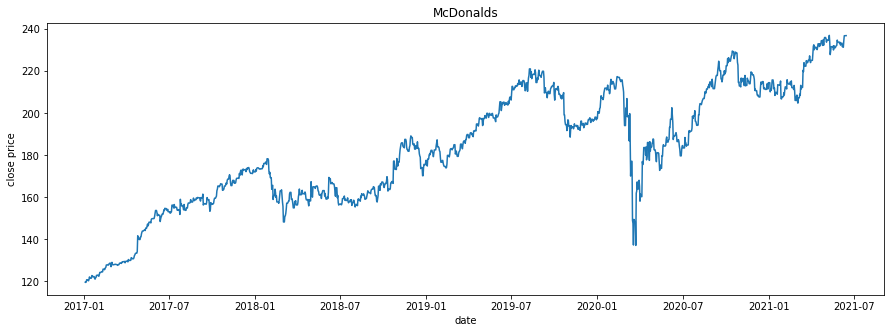

In [75]:
plt.plot(mcd['Close'])
plt.title('McDonalds')
plt.ylabel('close price')
plt.xlabel('date')

## Apply 'exponential moving average (EMA)' (30 days) strategy to McDonalds since 2017 

#### Exponential Moving Average (EMA) Strategy: https://tradingstrategyguides.com/ <br> The exponential moving average is a line on the price chart that uses a mathematical formula to smooth out the price action. It shows the average price over a certain period of time. The EMA formula puts more weight on the recent price. This means it’s more reliable because it reacts faster to the latest changes in price data.

total profit= 47.32%
number of transactions 25


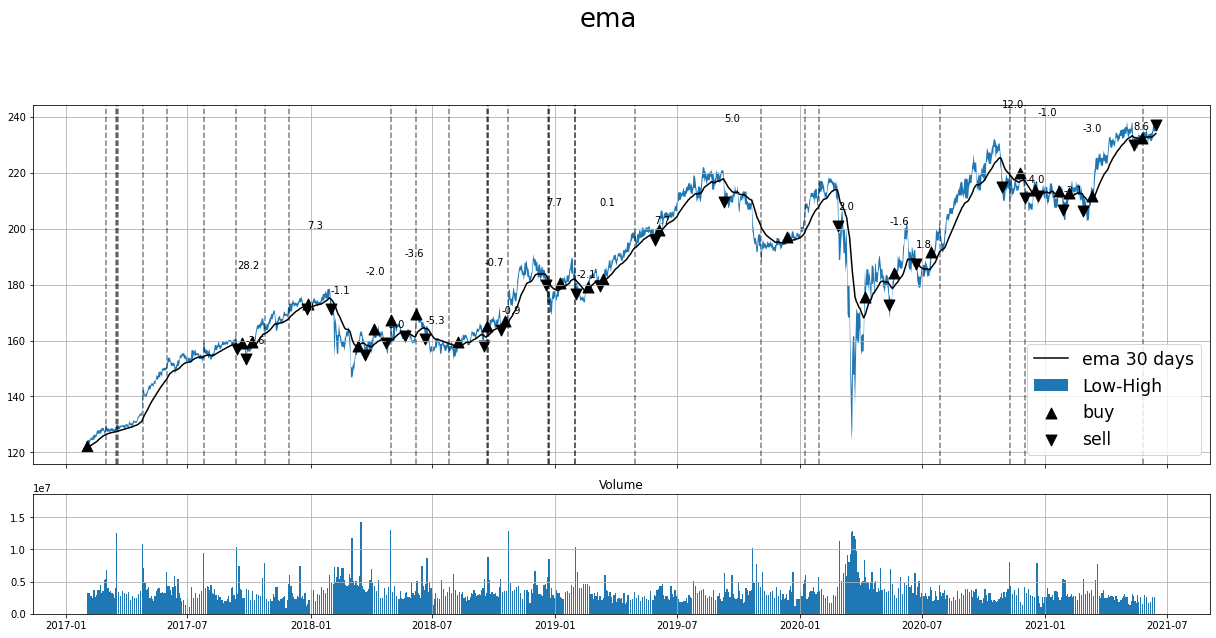

In [183]:
indicator_ema = Indicator(1,30,_,_)
indicator_ema.data_prep(mcd['2017-01-03':'2021-06-15'])

indicator_ema.buying_selling_days()
profit = indicator_ema.get_profit()
print(f'total profit= {profit:.2f}%')

num_trans = indicator_ema.number_transactions()
print(f'number of transactions {num_trans}')

indicator_ema.plot_results()

## 3) Amazon (amzn)


In [127]:
# PULL THE DATA
amazon = PullData("amzn",'2018-06-01',end_date)
amazon.request_yahoo()

# FILL MISSING VALUES
amazon.filling_missing_dates()
missing_dates_ = amazon.show_missing_dates()

#STORE THE DATA
amzn = amazon.get_data()

[*********************100%***********************]  1 of 1 completed
missing values: 345
      missing values
2020             113
2019             113
2018              67
2021              52


Text(0.5, 0, 'date')

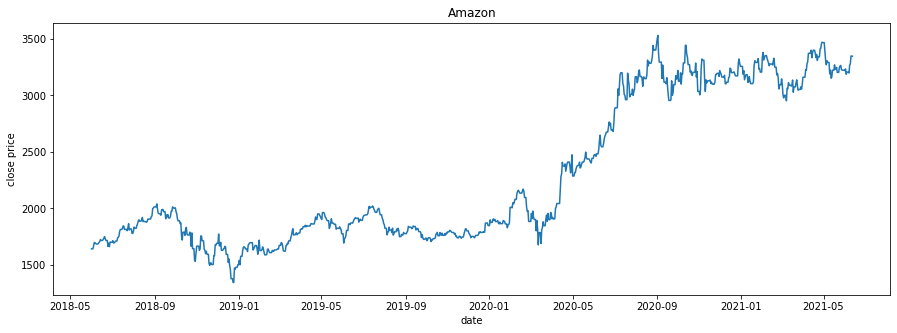

In [132]:
plt.plot(amzn['Close'])
plt.title('Amazon')
plt.ylabel('close price')
plt.xlabel('date')

# Apply 'MACD' strategy to Amazon since 2018 

#### MACD: www.ig.com <br>The MACD line and signal line can be utilised in much the same manner as a stochastic oscillator, with the crossover between the two lines providing buy and sell signals. As with most crossover strategies, a buy signal comes when the shorter-term, more reactive line – in this case the MACD line – crosses above the slower line – the signal line. Conversely, when the MACD line crosses below the signal line it provides a bearish sell signal.

total profit= 53.93%
number of transactions= 40


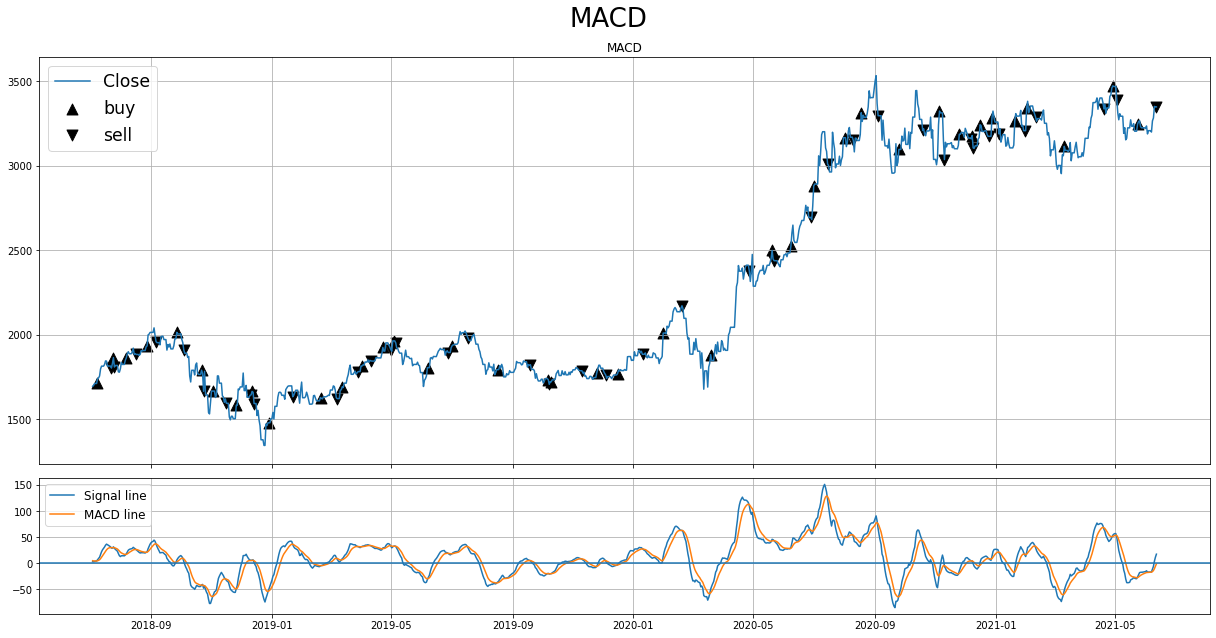

In [140]:
# {0:'sma',1:'ema',2:'cross simple average',3:'cross exp average',4:'MACD',5:'MACD conservative'} 
indicator_MACD = Indicator(4,_,_,_)
indicator_MACD.data_prep(amzn)

# WHEN TO BUY AND SELL ACCORDING TO THIS INDICATOR
buying_selling_dates = indicator_MACD.crossing_rolling_average()

# WHAT WOULD HAVE BEEN THE TOTAL PROFIT (%), ASSUMING THAT EACH TIME THE SAME AMOUNT IS INVSTED. 
# THE GAIN/LOOSE PORCENTAGE FOR EACH BUY/SELL TRANSACTION IS INDICATED NEXT TO EACH SELL SIGNAL
profit = indicator_MACD.get_profit()
print(f'total profit= {profit:.2f}%')

# HOW MANY TRANSACTIONS TOOK PLACE
num_trans = indicator_MACD.number_transactions()
print(f'number of transactions= {num_trans}')

# PLOT. DAYS WITH LARGE VOLUME ARE INDICATED WITH VERTICAL LINES IN THE TOP GRAPH
indicator_MACD.plot_results()

## Apply 'MACD Conservative' strategy to Amazon since 2018: Buy(sell) signals only when the lines cross below(above) zero (bottom graph)

total profit= 51.03%
number of transactions= 14


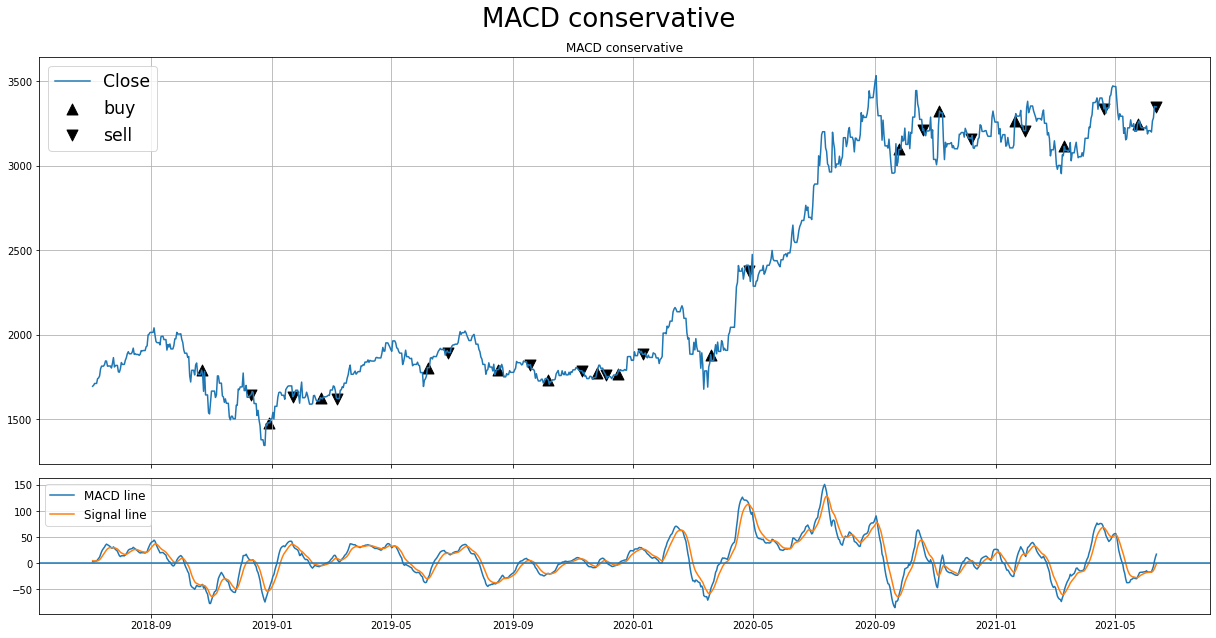

In [145]:
# {0:'sma',1:'ema',2:'cross simple average',3:'cross exp average',4:'MACD',5:'MACD conservative'} 
indicator_MACD = Indicator(5,_,_,_)
indicator_MACD.data_prep(amzn)

# WHEN TO BUY AND SELL ACCORDING TO THIS INDICATOR
buying_selling_dates = indicator_MACD.crossing_rolling_average()

# WHAT WOULD HAVE BEEN THE TOTAL PROFIT (%), ASSUMING THAT EACH TIME THE SAME AMOUNT IS INVESTED. 
# THE GAIN/LOOSE PORCENTAGE FOR EACH BUY/SELL TRANSACTION IS INDICATED NEXT TO EACH SELL SIGNAL
profit = indicator_MACD.get_profit()
print(f'total profit= {profit:.2f}%')

# HOW MANY TRANSACTIONS TOOK PLACE
num_trans = indicator_MACD.number_transactions()
print(f'number of transactions= {num_trans}')

# PLOT. DAYS WITH LARGE VOLUME ARE INDICATED WITH VERTICAL LINES IN THE TOP GRAPH
indicator_MACD.plot_results()

## Which indicator has been historically the best for Bitcoin and under what parameters?

### it takes around 10 minutes

In [146]:
dataframe = btc
periods = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,50,100,150]
indicators = {0:'sma',1:'ema',2:'cross_simple_average',3:'cross_exp_average',4:'MACD',5:'MACD_conservative'}
general_report = pd.DataFrame()
simple_report = pd.DataFrame()
cross_report = pd.DataFrame()
macd_report = pd.DataFrame()
time_zero = time.time()
for indi in indicators:
    indicator = indicators[indi]
    print(f'working on {indicator}')
    profits = []
    index=[]
    numb_transactions = []
    if indi in [0,1]:  # sma, ema
        for period in periods:
            indicator_ = Indicator(indi,period,1,11)
            indicator_.data_prep(dataframe)
            indicator_.buying_selling_days()
            profit = indicator_.get_profit()
            profits.append(profit)
            number_transaction = indicator_.number_transactions()
            numb_transactions.append(number_transaction)
        report = pd.DataFrame( {'indicator':indicator,
                                'return(%)':profits,'number_transactions':numb_transactions},
                              index=[[indicator + str(j) for j in periods]]) 
        simple_report = simple_report.append(report)
    elif indi in [2,3]: # cross avg
        for i,period_1 in enumerate(periods):
            print(f'      working on period {period_1}')
            for period_2 in periods[i+1:]:
                indicator_cross_average = Indicator(indi,1,period_1,period_2)
                indicator_cross_average.data_prep(dataframe)
                indicator_cross_average.crossing_rolling_average()
                profit = indicator_cross_average.get_profit()
                profits.append(profit)
                number_transaction = indicator_cross_average.number_transactions()
                numb_transactions.append(number_transaction)
                index.append(indicator + str(period_1) + '_' + str(period_2))
                
        report = pd.DataFrame( 
            {'indicator':indicator,
             'return(%)':profits,
             'number_transactions':numb_transactions},
            index=index)     
        cross_report = cross_report.append(report) 
    
    else:  # MACD
        indicator_macd = Indicator(indi,1,1,1)
        indicator_macd.data_prep(dataframe)
        indicator_macd.crossing_rolling_average()
        profit = indicator_macd.get_profit()
        profits.append(profit)
        number_transaction = indicator_macd.number_transactions()
        numb_transactions.append(number_transaction)
                   
        report = pd.DataFrame( 
            {'indicator':indicator,
             'return(%)':profits,
             'number_transactions':numb_transactions},
            index=[indicator])  
        macd_report = macd_report.append(report)

general_report = pd.concat([simple_report,cross_report,macd_report])
print(f'{round((time.time() - time_zero)/60,2)} minutes')

working on sma
working on ema
working on cross_simple_average
      working on period 3
      working on period 4
      working on period 5
      working on period 6
      working on period 7
      working on period 8
      working on period 9
      working on period 10
      working on period 11
      working on period 12
      working on period 13
      working on period 14
      working on period 15
      working on period 16
      working on period 17
      working on period 18
      working on period 19
      working on period 20
      working on period 25
      working on period 30
      working on period 50
      working on period 100
      working on period 150
working on cross_exp_average
      working on period 3
      working on period 4
      working on period 5
      working on period 6
      working on period 7
      working on period 8
      working on period 9
      working on period 10
      working on period 11
      working on period 12
      working on period 13
   

In [163]:
general_report.sort_values(by='return(%)',ascending=False).head(20)

,indicator,return(%),number_transactions
"(sma100,)",sma,590.419581,6
cross_exp_average7_100,cross_exp_average,577.520398,7
cross_exp_average9_30,cross_exp_average,560.031876,14
cross_simple_average3_50,cross_simple_average,547.341592,17
cross_simple_average30_100,cross_simple_average,540.439350,4
cross_simple_average30_50,cross_simple_average,537.686037,11
cross_exp_average10_30,cross_exp_average,534.188834,13
cross_exp_average12_25,cross_exp_average,533.597489,13
cross_exp_average16_20,cross_exp_average,530.679287,13
cross_exp_average17_19,cross_exp_average,530.679287,13


590.4195805831997


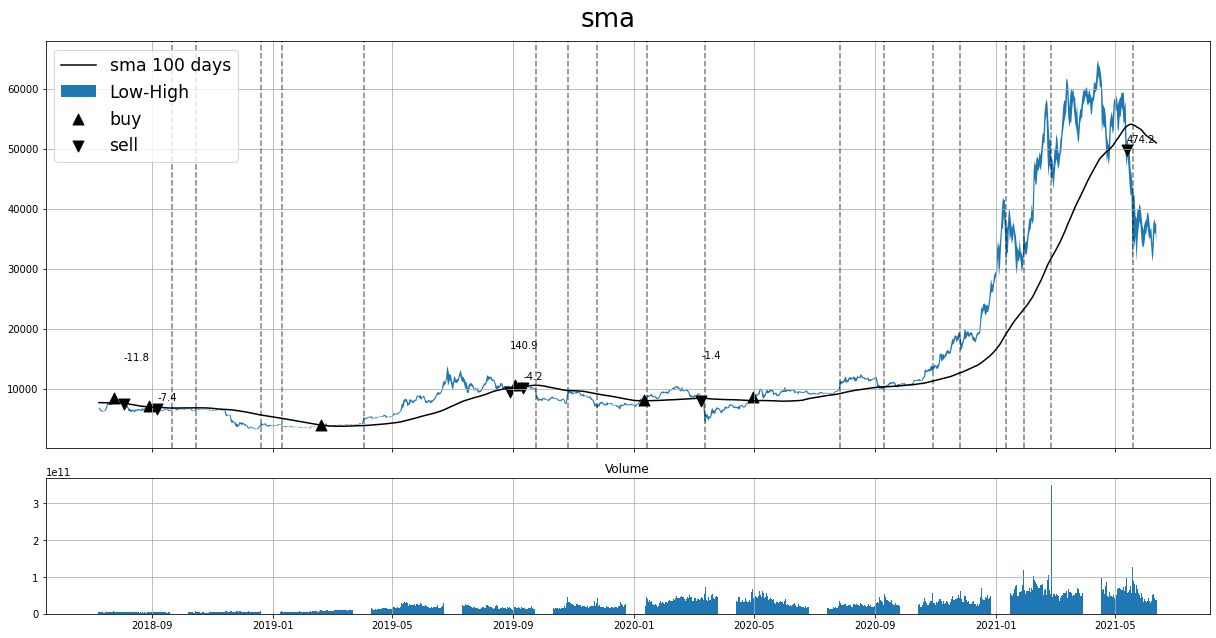

Best performance


In [171]:
indicator_sma = Indicator(0,100,_,_)
indicator_sma.data_prep(btc)
indicator_sma.buying_selling_days()
profit = indicator_sma.get_profit()
print(profit)
indicator_sma.plot_results()
print("Best performance")

577.5203978460703


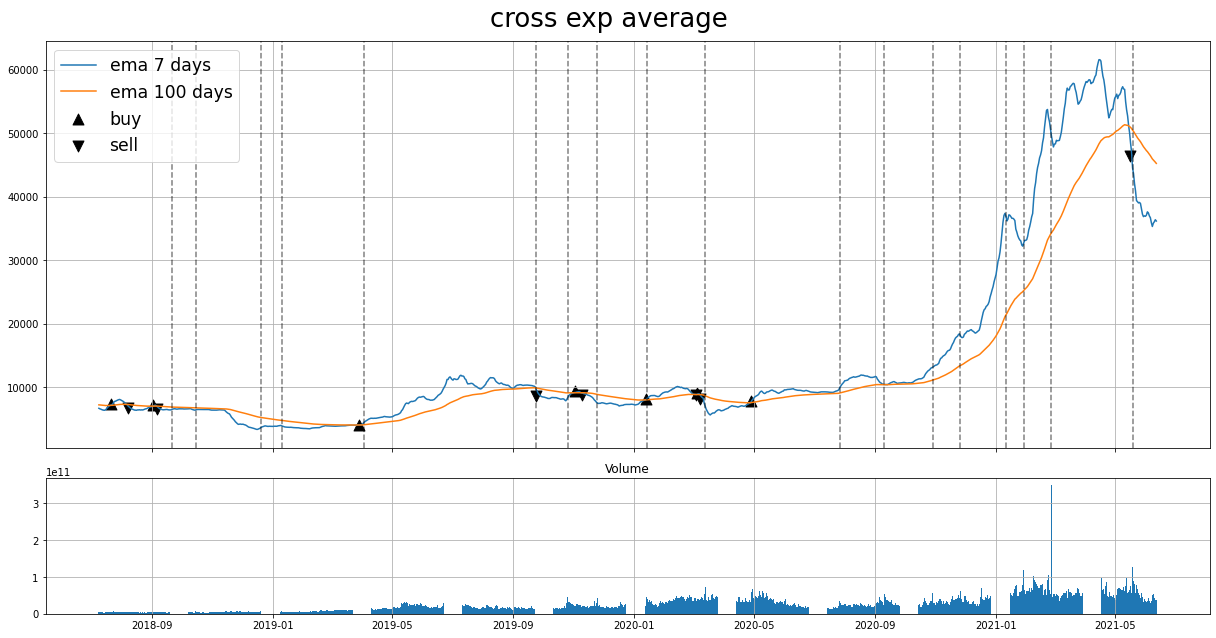

Second best performance


In [170]:
indicator_exp_cross_average = Indicator(3,_,7,100)
indicator_exp_cross_average.data_prep(btc)
indicator_exp_cross_average.crossing_rolling_average()
profit = indicator_exp_cross_average.get_profit()
print(profit)
indicator_exp_cross_average.plot_results()
print("Second best performance")

In [172]:
general_report.to_csv(r'bitcoin_report.csv')

In [ ]:
#pd.read_csv('bitcoin_report.csv')

## Which indicator perfomed best for Bitcoin before the strong increse in May 2020?

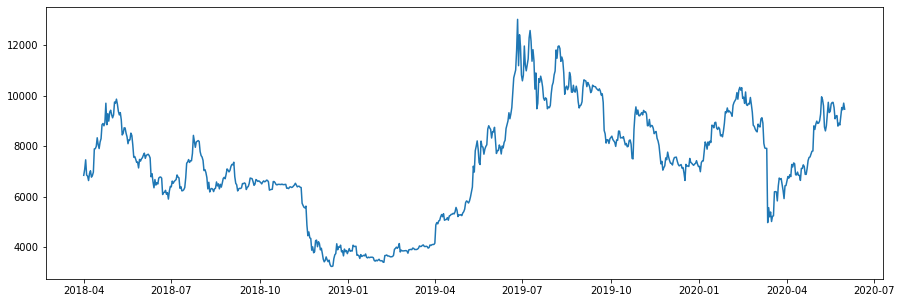

In [175]:
plt.plot(btc['Close'][:'2020-05'])

In [177]:
dataframe = btc[:'2020-05']
periods = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,50,100,150]
indicators = {0:'sma',1:'ema',2:'cross_simple_average',3:'cross_exp_average',4:'MACD',5:'MACD_conservative'}
general_report = pd.DataFrame()
simple_report = pd.DataFrame()
cross_report = pd.DataFrame()
macd_report = pd.DataFrame()
time_zero = time.time()
for indi in indicators:
    indicator = indicators[indi]
    print(f'working on {indicator}')
    profits = []
    index=[]
    numb_transactions = []
    if indi in [0,1]:  # sma, ema
        for period in periods:
            indicator_ = Indicator(indi,period,1,11)
            indicator_.data_prep(dataframe)
            indicator_.buying_selling_days()
            profit = indicator_.get_profit()
            profits.append(profit)
            number_transaction = indicator_.number_transactions()
            numb_transactions.append(number_transaction)
        report = pd.DataFrame( {'indicator':indicator,
                                'return(%)':profits,'number_transactions':numb_transactions},
                              index=[[indicator + str(j) for j in periods]]) 
        simple_report = simple_report.append(report)
    elif indi in [2,3]: # cross avg
        for i,period_1 in enumerate(periods):
            print(f'      working on period {period_1}')
            for period_2 in periods[i+1:]:
                indicator_cross_average = Indicator(indi,1,period_1,period_2)
                indicator_cross_average.data_prep(dataframe)
                indicator_cross_average.crossing_rolling_average()
                profit = indicator_cross_average.get_profit()
                profits.append(profit)
                number_transaction = indicator_cross_average.number_transactions()
                numb_transactions.append(number_transaction)
                index.append(indicator + str(period_1) + '_' + str(period_2))
                
        report = pd.DataFrame( 
            {'indicator':indicator,
             'return(%)':profits,
             'number_transactions':numb_transactions},
            index=index)     
        cross_report = cross_report.append(report) 
    
    else:  # MACD
        indicator_macd = Indicator(indi,1,1,1)
        indicator_macd.data_prep(dataframe)
        indicator_macd.crossing_rolling_average()
        profit = indicator_macd.get_profit()
        profits.append(profit)
        number_transaction = indicator_macd.number_transactions()
        numb_transactions.append(number_transaction)
                   
        report = pd.DataFrame( 
            {'indicator':indicator,
             'return(%)':profits,
             'number_transactions':numb_transactions},
            index=[indicator])  
        macd_report = macd_report.append(report)

general_report = pd.concat([simple_report,cross_report,macd_report])
print(f'{round((time.time() - time_zero)/60,2)} minutes')

working on sma
working on ema
working on cross_simple_average
      working on period 3
      working on period 4
      working on period 5
      working on period 6
      working on period 7
      working on period 8
      working on period 9
      working on period 10
      working on period 11
      working on period 12
      working on period 13
      working on period 14
      working on period 15
      working on period 16
      working on period 17
      working on period 18
      working on period 19
      working on period 20
      working on period 25
      working on period 30
      working on period 50
      working on period 100
      working on period 150
working on cross_exp_average
      working on period 3
      working on period 4
      working on period 5
      working on period 6
      working on period 7
      working on period 8
      working on period 9
      working on period 10
      working on period 11
      working on period 12
      working on period 13
   

In [180]:
general_report.sort_values(by='return(%)',ascending=False)

,indicator,return(%),number_transactions
cross_simple_average30_50,cross_simple_average,181.602678,9
cross_exp_average16_19,cross_exp_average,179.127265,9
cross_exp_average15_20,cross_exp_average,177.639312,9
cross_exp_average9_30,cross_exp_average,177.488295,11
cross_exp_average12_25,cross_exp_average,174.724721,9
...,...,...,...
cross_exp_average25_100,cross_exp_average,11.893803,4
cross_exp_average30_150,cross_exp_average,8.876048,3
cross_exp_average30_100,cross_exp_average,5.775415,4
MACD_conservative,MACD_conservative,-11.920252,7


181.60267792195327


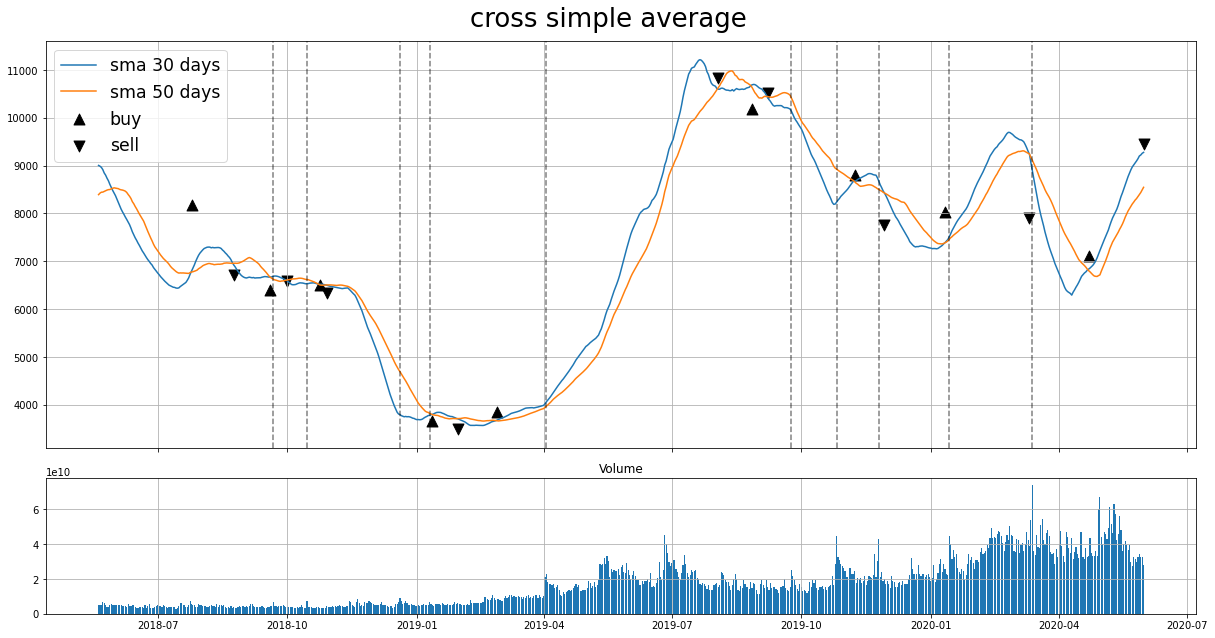

Best performance


In [181]:
indicator_exp_cross_average = Indicator(2,_,30,50)
indicator_exp_cross_average.data_prep(btc[:'2020-05'])
indicator_exp_cross_average.crossing_rolling_average()
profit = indicator_exp_cross_average.get_profit()
print(profit)
indicator_exp_cross_average.plot_results()
print("Best performance")